# TFIM 初期状態と時間発展

In [3]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec
from functools import lru_cache

In [23]:
# ========= キャッシュ付きヘルパ =========

@lru_cache(maxsize=None)
def get_ops(N):
    """Nだけで決まる演算子たち"""
    cut_pos = N // 2 - 1
    sx, sz = qt.sigmax(), qt.sigmaz()
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    def H_exchange(i):
        return Sz[i] * Sz[i+1]

    Hcut_unit   = H_exchange(cut_pos)
    Hex_rest_unit = sum(H_exchange(i) for i in range(N-1) if i != cut_pos)
    Hhx_unit    = sum(Sx[i] for i in range(N))

    left_sites = list(range(N//2))
    return Hcut_unit, Hex_rest_unit, Hhx_unit, left_sites


@lru_cache(maxsize=None)
def get_psi0(N, J, hx):
    """(N, J, hx)で決まる初期基底状態"""
    Hcut_unit, Hex_rest_unit, Hhx_unit, _ = get_ops(N)
    H_full = -J * (Hcut_unit + Hex_rest_unit) - hx * Hhx_unit
    _, psi0 = H_full.groundstate(sparse=True)
    return psi0

# シミュレーション関数
# ========= メイン: Tcut ごとの時間発展 =========

def simulate(N, J, hx, Tcut):
    Hcut_unit, Hex_rest_unit, Hhx_unit, _ = get_ops(N)
    psi0 = get_psi0(N, J, hx)

    # Tcut=0 は「そもそも切ってないので完全一致」として即返す
    if Tcut == 0.0:
        return 1.0

    # H(t) = H_static + (-J * Hcut_unit) * ramp(t)
    H_static = -J * Hex_rest_unit - hx * Hhx_unit

    def ramp(t, Tcut):
        if Tcut == 0.0:
            return 1.0 if t <= 0.0 else 0.0
        if t <= 0.0:
            return 1.0
        if t >= Tcut:
            return 0.0
        return 1.0 - t / Tcut

    Ht = [H_static, [-J * Hcut_unit, lambda t, args: ramp(t, Tcut)]]

    # 0〜Tcut を分割（最後の点だけ使う）
    tlist = np.linspace(0.0, Tcut, 51)

    opts = {
        "method": "bdf",        # stiff系
        "rtol": 1e-6,
        "atol": 1e-8,
        "nsteps": 200000,
        "store_states": True,
    }

    result = qt.sesolve(Ht, psi0, tlist, options=opts)
    psi_init = result.states[0]

    fid = np.array([abs(st.overlap(psi_init)) for st in result.states], dtype=float)
    return tlist, fid, psi_init

hx = 0.1
check fid[0] is 1.0 = 1.0
initial state is Quantum object: dims=[[2, 2, 2, 2, 2, 2], [1]], shape=(64, 1), type='ket', dtype=Dense
Qobj data =
[[2.91209060e-01-6.41440447e-01j]
 [1.45611603e-02-3.20735803e-02j]
 [7.29882250e-03-1.60769722e-02j]
 [1.09999559e-03-2.42293857e-03j]
 [7.28518398e-03-1.60469309e-02j]
 [3.67437876e-04-8.09348154e-04j]
 [3.70836353e-04-8.16833912e-04j]
 [1.82005411e-04-4.00899726e-04j]
 [7.28518398e-03-1.60469309e-02j]
 [3.65629173e-04-8.05364160e-04j]
 [1.84066579e-04-4.05439819e-04j]
 [5.48068696e-05-1.20722009e-04j]
 [3.68579721e-04-8.11863274e-04j]
 [4.57069223e-05-1.00677735e-04j]
 [7.75922032e-05-1.70910814e-04j]
 [1.09999559e-03-2.42293856e-03j]
 [7.29882250e-03-1.60769722e-02j]
 [3.66082482e-04-8.06362654e-04j]
 [1.83839496e-04-4.04939627e-04j]
 [4.57069223e-05-1.00677735e-04j]
 [1.84066579e-04-4.05439819e-04j]
 [1.83150781e-05-4.03422608e-05j]
 [2.74496718e-05-6.04628500e-05j]
 [3.67437875e-04-8.09348153e-04j]
 [3.70836353e-04-8.16833912e-04j]

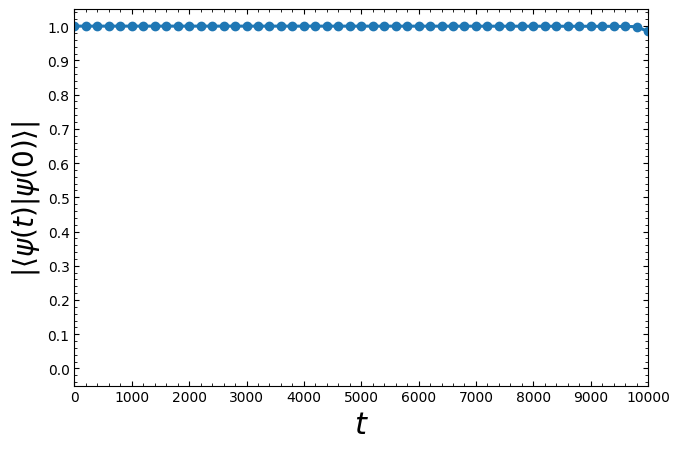

In [29]:
# ========= プロット =========

hx_list = [0.1]
N_list = [6]
# Tcut_list = np.linspace(0.0, 10000.0, 101)
Tcut = 10000
J = 1.0

markers = ['o', '^', 's', 'D', 'x']
nstamp = '-'.join(map(str, N_list))

for i, hx in enumerate(hx_list):
    fig, ax = plt.subplots(figsize=(6.9, 4.6))
    print(f"hx = {hx}")
    for j, N in enumerate(N_list):
        mk = markers[j % len(markers)]
        tlist, fid, psi_init = simulate(N=N, J=J, hx=hx, Tcut=Tcut)
        ax.plot(
            tlist, fid,
            marker=mk,
            linewidth=2.2,
            markersize=6.0,
            label=rf"$N={N}$",
        )
        print(f"check fid[0] is {fid[0]} = 1.0")
        print(f"initial state is {psi_init}")

    ax.set_xlim(Tcut_list.min(), Tcut_list.max())
    ax.set_ylim(-0.05, 1.05)  # |overlap| なので 0〜1
    ax.set_xlabel(r"$t$", fontsize=22)
    ax.set_ylabel(r"$|\langle\psi(t)|\psi(0)\rangle|$", fontsize=20)
    
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.xaxis.set_major_locator(MultipleLocator(1000))
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True)
    # ax.legend(frameon=False, fontsize=14)
    fig.tight_layout()
    
    OUTDIR = Path("../charts/TFIM")
    OUTDIR.mkdir(parents=True, exist_ok=True)
    # fig.savefig(OUTDIR / f"fid_init_fin_N{nstamp}_hx{hx}.pdf", bbox_inches="tight", dpi=300)
    
    plt.show()